# Fine tuning classification example
Copyright 2023, OpenAI & Denis Rothman MIT License

OpenAI fine-tunes an ada classifier to distinguish between the two sports: Baseball and Hockey.

This notebook is a modified version of   
[OpenAI's Fine-tuned classification notebook](https://github.com/openai/openai-cookbook/blob/main/examples/Fine-tuned_classification.ipynb)

Denis Rothman has modified parts of this notebook for educational purposes (sections, comments, and code). The main sections titles are those in Fine_tuning_GPT_3.ipynb in the GitHub repository. 2 sections were added:

2.1.Measuring the model's accuracy  
3.1.Generalization

**Note**: Y*ou will have to run the fine-tuning process to create your model and then replace the model names in this notebook with your model name.*

# Installing OpenAI

In [ ]:
try:
  import openai
except:
  !pip install openai
  import openai

In [ ]:
#You can retrieve your API key from a file(1)
# or enter it manually(2)

#Comment this cell if you want to enter your key manually.
#(1)Retrieve the API Key from a file
#Store you key in a file and read it(you can type it directly in the notebook but it will be visible for somebody next to you)
from google.colab import drive
drive.mount('/content/drive')
f = open("drive/MyDrive/files/api_key.txt", "r")
API_KEY=f.readline()
f.close()

Mounted at /content/drive


In [ ]:
#(2) Enter your manually by
# replacing API_KEY by your key.
#The OpenAI Key
import os
os.environ['OPENAI_API_KEY'] =API_KEY
openai.api_key = os.getenv("OPENAI_API_KEY")

# 1.Preparing the dataset

Retrieving the dataset
 The newsgroup dataset can be loaded using sklearn.

In [ ]:
from sklearn.datasets import fetch_20newsgroups
import pandas as pd
import openai

categories = ['rec.sport.baseball', 'rec.sport.hockey']
sports_dataset = fetch_20newsgroups(subset='train', shuffle=True, random_state=42, categories=categories)

First we will look at the data itself:

In [ ]:
print(sports_dataset['data'][0])

From: dougb@comm.mot.com (Doug Bank)
Subject: Re: Info needed for Cleveland tickets
Reply-To: dougb@ecs.comm.mot.com
Organization: Motorola Land Mobile Products Sector
Distribution: usa
Nntp-Posting-Host: 145.1.146.35
Lines: 17

In article <1993Apr1.234031.4950@leland.Stanford.EDU>, bohnert@leland.Stanford.EDU (matthew bohnert) writes:

|> I'm going to be in Cleveland Thursday, April 15 to Sunday, April 18.
|> Does anybody know if the Tribe will be in town on those dates, and
|> if so, who're they playing and if tickets are available?

The tribe will be in town from April 16 to the 19th.
There are ALWAYS tickets available! (Though they are playing Toronto,
and many Toronto fans make the trip to Cleveland as it is easier to
get tickets in Cleveland than in Toronto.  Either way, I seriously
doubt they will sell out until the end of the season.)

-- 
Doug Bank                       Private Systems Division
dougb@ecs.comm.mot.com          Motorola Communications Sector
dougb@nwu.edu       

In [ ]:
sports_dataset.target_names[sports_dataset['target'][0]]

'rec.sport.baseball'

In [ ]:
len_all, len_baseball, len_hockey = len(sports_dataset.data), len([e for e in sports_dataset.target if e == 0]), len([e for e in sports_dataset.target if e == 1])
print(f"Total examples: {len_all}, Baseball examples: {len_baseball}, Hockey examples: {len_hockey}")

Total examples: 1197, Baseball examples: 597, Hockey examples: 600


One sample from the baseball category can be seen above. It is an email to a mailing list. We can observe that we have 1197 examples in total, which are evenly split between the two sports.

## 1.1. Preparing the data in JSON

We transform the dataset into a pandas dataframe, with a column for prompt and completion. The prompt contains the email from the mailing list, and the completion is a name of the sport, either hockey or baseball. For demonstration purposes only and speed of fine-tuning we take only 300 examples. In a real use case the more examples the better the performance.

In [ ]:
import pandas as pd

labels = [sports_dataset.target_names[x].split('.')[-1] for x in sports_dataset['target']]
texts = [text.strip() for text in sports_dataset['data']]
df = pd.DataFrame(zip(texts, labels), columns = ['prompt','completion']) #[:300]
df.head()

,prompt,completion
0,From: dougb@comm.mot.com (Doug Bank)\nSubject:...,baseball
1,From: gld@cunixb.cc.columbia.edu (Gary L Dare)...,hockey
2,From: rudy@netcom.com (Rudy Wade)\nSubject: Re...,baseball
3,From: monack@helium.gas.uug.arizona.edu (david...,hockey
4,Subject: Let it be Known\nFrom: <ISSBTL@BYUVM....,baseball


Both baseball and hockey are single tokens. We save the dataset as a jsonl file.

In [ ]:
df.to_json("sport2.jsonl", orient='records', lines=True)

##  1.2. Converting the data to JSONL
We can now use a data preparation tool which will suggest a few improvements to our dataset before fine-tuning. Before launching the tool we update the openai library to ensure we're using the latest data preparation tool. We additionally specify `-q` which auto-accepts all suggestions.

In [ ]:
!openai tools fine_tunes.prepare_data -f sport2.jsonl -q

Analyzing...

- Your file contains 1197 prompt-completion pairs
- Based on your data it seems like you're trying to fine-tune a model for classification
- For classification, we recommend you try one of the faster and cheaper models, such as `ada`
- For classification, you can estimate the expected model performance by keeping a held out dataset, which is not used for training
- There are 11 examples that are very long. These are rows: [134, 200, 281, 320, 404, 595, 704, 838, 1113, 1139, 1174]
For conditional generation, and for classification the examples shouldn't be longer than 2048 tokens.
- Your data does not contain a common separator at the end of your prompts. Having a separator string appended to the end of the prompt makes it clearer to the fine-tuned model where the completion should begin. See https://platform.openai.com/docs/guides/fine-tuning/preparing-your-dataset for more detail and examples. If you intend to do open-ended generation, then you should leave the prompts e

The tool helpfully suggests a few improvements to the dataset and splits the dataset into training and validation set.

A suffix between a prompt and a completion is necessary to tell the model that the input text has stopped, and that it now needs to predict the class. Since we use the same separator in each example, the model is able to learn that it is meant to predict either baseball or hockey following the separator.
A whitespace prefix in completions is useful, as most word tokens are tokenized with a space prefix.
The tool also recognized that this is likely a classification task, so it suggested to split the dataset into training and validation datasets. This will allow us to easily measure expected performance on new data.

# 2.Fine-tuning an original model

We will fine-tune an ada model

The tool suggests we run the following command to train the dataset. Since this is a classification task, we would like to know what the generalization performance on the provided validation set is for our classification use case. The tool suggests to add `--compute_classification_metrics --classification_positive_class " baseball"` in order to compute the classification metrics.

We can simply copy the suggested command from the CLI tool. We specifically add `-m ada` to fine-tune a cheaper and faster ada model, which is usually comperable in performance to slower and more expensive models on classification use cases.

In [ ]:
!openai api fine_tunes.create -t "sport2_prepared_train.jsonl" -v "sport2_prepared_valid.jsonl" --compute_classification_metrics --classification_positive_class " baseball" -m ada

In [ ]:
!openai api fine_tunes.follow -i [MODEL_ID]

In [ ]:
#Stream interrupted (client disconnected).
#To resume the stream, run:
#!openai api fine_tunes.follow -i [YOUR_MODEL]

Let's retrieve the model to see if it is fully fine-tuned and ready as we did in section 4. in Fine_tuning_GPT_3.ipynb

In [ ]:
#ENTER your model name:
response = openai.FineTune.retrieve('MODEL_ID')
print(response)

In [ ]:
#ENTER your model name:
response = openai.FineTune.retrieve('MODEL_ID')
print(response)

When the model has been trained,  we can  we can use it for an inference task.

## 2.1. Measuring the model's Accuracy
We can now download the results file to observe the expected performance on a held out validation set.

In [ ]:
!openai api fine_tunes.results -i [YOUR_MODEL] > results.csv

In [41]:
results = pd.read_csv('results.csv')
results[results['classification/accuracy'].notnull()].tail()

,step,elapsed_tokens,elapsed_examples,training_loss,training_sequence_accuracy,training_token_accuracy,validation_loss,validation_sequence_accuracy,validation_token_accuracy,classification/accuracy,classification/precision,classification/recall,classification/auroc,classification/auprc,classification/f1.0
930,931,423307,931,0.024512,1.0,1.0,NaN,NaN,NaN,0.936975,0.990476,0.881356,0.995127,0.995035,0.932735
1860,1861,846541,1861,0.024563,1.0,1.0,NaN,NaN,NaN,0.995798,0.991667,1.000000,0.999929,0.999930,0.995816
2790,2791,1270015,2791,0.010276,1.0,1.0,NaN,NaN,NaN,0.995798,0.991597,1.000000,0.999929,0.999928,0.995781
3720,3721,1693081,3721,0.010245,1.0,1.0,0.017013,1.0,1.0,0.995798,0.991736,1.000000,0.999929,0.999931,0.995851


The accuracy reaches 99.6%. On the plot below we can see how accuracy on the validation set increases during the training run.

**ChatGPT Plus, GPT-4 describes the columns contained in the metrics file.**

This log file or report was generated during the machine learning training process. It records key metrics for the training and validation process. Here's what each column means:

1. `step`: This is the iteration number. In each step, a batch of examples is processed by the model.

2. `elapsed_tokens`: This is the total number of tokens processed so far. A token is typically a word or a character, depending on the language model.

3. `elapsed_examples`: This is the total number of examples processed so far. An example corresponds to a single data point in your training or validation set.

4. `training_loss`: This is the loss value for the training set. The loss is a measure of the difference between the model's predictions and the actual values in the training set. The goal of training is to minimize this value.

5. `training_sequence_accuracy`: This is the sequence-level accuracy for the training set. It measures how often the model correctly predicts entire sequences in the training set.

6. `training_token_accuracy`: This is the token-level accuracy for the training set. It measures how often the model correctly predicts individual tokens in the training set.

7. `validation_loss`: This is the loss value for the validation set. It's similar to the training loss, but it's calculated using a separate dataset that the model doesn't train on. This helps to ensure that the model is not just memorizing the training data, but is actually learning to generalize to new data.

8. `validation_sequence_accuracy`: This is the sequence-level accuracy for the validation set. It measures how often the model correctly predicts entire sequences in the validation set.

9. `validation_token_accuracy`: This is the token-level accuracy for the validation set. It measures how often the model correctly predicts individual tokens in the validation set.

10. `classification/accuracy`: This is the overall accuracy of the model's classifications.

11. `classification/precision`: This is the precision of the model's classifications. Precision is the number of true positives divided by the sum of true positives and false positives. It measures the model's ability to correctly identify only relevant instances.

12. `classification/recall`: This is the recall of the model's classifications. Recall is the number of true positives divided by the sum of true positives and false negatives. It measures the model's ability to find all the relevant instances.

13. `classification/auroc`: This stands for "Area Under the Receiver Operating Characteristic curve". It measures the model's ability to distinguish between classes.

14. `classification/auprc`: This stands for "Area Under the Precision-Recall Curve". It also measures the model's ability to distinguish between classes, but it gives more weight to precision.

15. `classification/f1.0`: This is the F1 score of the model's classifications, which is the harmonic mean of precision and recall. It provides a single measure of the model's performance that balances both precision and recall.

Empty entries in the log indicate that the particular metric was not computed or not applicable for that step.

<Axes: >

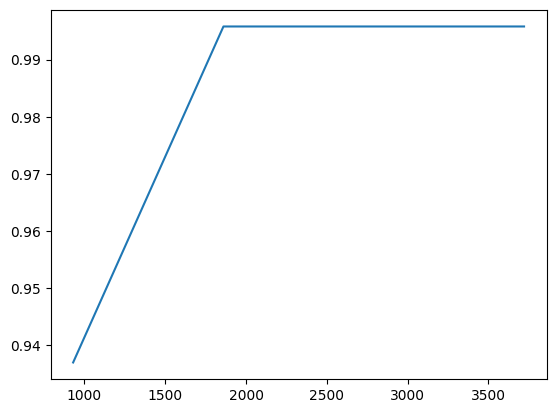

In [35]:
results[results['classification/accuracy'].notnull()]['classification/accuracy'].plot()

# 3.Running the fine-tuned GPT-3 model

We will now run the model for a classification task

We can now call the model to get the predictions.

In [42]:
test = pd.read_json('sport2_prepared_valid.jsonl', lines=True)
test.head(10)

,prompt,completion
0,From: gld@cunixb.cc.columbia.edu (Gary L Dare)...,hockey
1,From: smorris@venus.lerc.nasa.gov (Ron Morris ...,hockey
2,From: golchowy@alchemy.chem.utoronto.ca (Geral...,hockey
3,From: krattige@hpcc01.corp.hp.com (Kim Krattig...,baseball
4,From: warped@cs.montana.edu (Doug Dolven)\nSub...,baseball
5,From: jerry@sheldev.shel.isc-br.com (Gerald La...,baseball
6,From: kime@mongoose.torolab.ibm.com (Edward Ki...,baseball
7,From: cmk@athena.mit.edu (Charles M Kozierok)\...,baseball
8,From: pkortela@snakemail.hut.fi (Petteri Korte...,hockey
9,From: gak@wrs.com (Richard Stueven)\nSubject: ...,hockey


We need to use the same separator following the prompt which we used during fine-tuning. In this case it is `\n\n###\n\n`. Since we're concerned with classification, we want the temperature to be as low as possible, and we only require one token completion to determine the prediction of the model.

In [37]:
ft_model ='[MODEL_NAME]'
res = openai.Completion.create(model=ft_model, prompt=test['prompt'][0] + '\n\n###\n\n', max_tokens=1, temperature=0)
res['choices'][0]['text']

' hockey'

To get the log probabilities, we can specify logprobs parameter on the completion request

In [43]:
res = openai.Completion.create(model=ft_model, prompt=test['prompt'][0] + '\n\n###\n\n', max_tokens=1, temperature=0, logprobs=2)
res['choices'][0]['logprobs']['top_logprobs'][0]

<OpenAIObject at 0x7f1c298501d0> JSON: {
  " hockey": -0.00018343095,
  " Hockey": -8.753902
}

We can see that the model predicts hockey as a lot more likely than baseball, which is the correct prediction. By requesting log_probs, we can see the prediction (log) probability for each class.

## 3.1. Generalization
Interestingly, our fine-tuned classifier is quite versatile. Despite being trained on emails to different mailing lists, it also successfully predicts tweets.

In [39]:
sample_hockey_tweet = """Thank you to the
@Canes
 and all you amazing Caniacs that have been so supportive! You guys are some of the best fans in the NHL without a doubt! Really excited to start this new chapter in my career with the
@DetroitRedWings
 !!"""
res = openai.Completion.create(model=ft_model, prompt=sample_hockey_tweet + '\n\n###\n\n', max_tokens=1, temperature=0, logprobs=2)
res['choices'][0]['text']

' hockey'

In [40]:
sample_baseball_tweet="""BREAKING: The Tampa Bay Rays are finalizing a deal to acquire slugger Nelson Cruz from the Minnesota Twins, sources tell ESPN."""
res = openai.Completion.create(model=ft_model, prompt=sample_baseball_tweet + '\n\n###\n\n', max_tokens=1, temperature=0, logprobs=2)
res['choices'][0]['text']

' baseball'

# 4. Further testing

In [50]:
response = openai.Completion.create(
  model="text-davinci-003",
  prompt="Please classify the following text as either \"hockey\" or \"baseball\":\n\nThis game would have been great as part of a double-header on ABC or ESPN; the league would have been able to push back-to-back wins by Le Magnifique and The Great One. Unfortunately, the only network that would have done that was SCA",
  temperature=1,
  max_tokens=10,
  top_p=1,
  frequency_penalty=0,
  presence_penalty=0
)

In [51]:
response

<OpenAIObject text_completion id=cmpl-7UKcQNPteF0IZhejYomBVepx5C9ZP at 0x7f1c29572250> JSON: {
  "id": "cmpl-7UKcQNPteF0IZhejYomBVepx5C9ZP",
  "object": "text_completion",
  "created": 1687463454,
  "model": "text-davinci-003",
  "choices": [
    {
      "text": ".\n\nHockey",
      "index": 0,
      "logprobs": null,
      "finish_reason": "stop"
    }
  ],
  "usage": {
    "prompt_tokens": 73,
    "completion_tokens": 5,
    "total_tokens": 78
  }
}